<a href="https://colab.research.google.com/github/xcomponent/chatbot-nlp/blob/main/compare_tfidf_vs_bert_features_in_intent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook studies the use of different feature embeddings in intent prediction.

In the following, we compare two features which are usually used in NLP tasks: 
- TF-IDF 
- BERT-based semantic features



# Install / initialize

In [ ]:
from google.colab import drive
drive.mount('/colab-data-drive')

Mounted at /colab-data-drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.5 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 
     |████████████████████████████████| 182 kB 75.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 1.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=95902853674f2d7b213c078c1dc0d8eb2fbbaf35270056817fc8125e7c7bd22b
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
import pandas
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from transformers import AutoConfig, AutoModel, AutoTokenizer

import torch

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from pprint import pprint

import time

from sklearn.preprocessing import Normalizer


# Reference data
https://nlpforfrench.fr/transformers/02_firstBert_fr.html

In [ ]:
url="https://raw.githubusercontent.com/nlpinfrench/nlpinfrench.github.io/master/source/labeled_data.csv"

ref_df = pandas.read_csv(url,header=1,names = ['a','review','b','c','temps','e'])

ref_df = ref_df[["review","temps"]]
ref_df.sample(5)

print('Number of sentences: {:,}\n'.format(ref_df.shape[0]))
print('Number of sentences per class :')
print(ref_df['temps'].value_counts())

Number of sentences: 322

Number of sentences per class :
0    233
1     89
Name: temps, dtype: int64


# Configs

In [ ]:
pre_trained_model = "camembert-base" #@param ["camembert-base","camembert/camembert-base-wikipedia-4gb",'bert-base-multilingual-cased','bert-base-multilingual-uncased']

In [ ]:
features_name = "tfidf" #@param ["tfidf", "bert_1_layer", "bert_4_layers_concatenated", "bert_4_layers_avg", "bert_4_layers_max"]

In [ ]:
classifier = None
classifier_name = "SVM" #@param ["LogisticRegression", "SVM"]

# Load and prepare data

### Training data

In [ ]:
def load_data(training_data_fn):

    messages = []

    df = pandas.read_excel(training_data_fn, header = None)

    return df

In [ ]:
# training_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/6377b04fa1ef9405a2a0575b_training_data_FR.xlsx" # 39 intents smalltalks
# training_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/pfs_SAV_training_data_FR.xlsx" # pfs SAV
training_data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/training_data/test_to_remove.xlsx"

df = load_data(training_data_fn)

all_messages = []
all_intents = []

intents_id_name = {}

for i, row in df.iterrows():
  message, intent, intent_name, language = row
  all_messages.append(message)
  all_intents.append(intent_name)

  if intent not in intents_id_name:
      intents_id_name[intent] = intent_name

print(f"Training data has {len(all_messages)} messages")
print(f"Training data contains {len(set(all_intents))} intents")

Training data has 687 messages
Training data contains 39 intents


In [ ]:
pprint(intents_id_name)

{'5f86f3b34edf1d3f90d33fd0': 'Prendre des nouvelles du chatbot',
 '5f86f3b34edf1d3f90d33fdf': 'Demander le nom du Chatbot',
 '5f86f3b34edf1d3f90d3400c': "Demander l'âge du Chatbot",
 '5f86f3b44edf1d3f90d34188': 'Demander une réponse au chatbot',
 '5f86f3b44edf1d3f90d341a9': 'Critiquer le chatbot',
 '5f86f3b64edf1d3f90d345c0': 'Demander au Chatbot sa date de naissance',
 '5f86f3b74edf1d3f90d345e5': "Demander au chatbot s'il est réel",
 '5f86f3b74edf1d3f90d3460f': "Dire au Chatbot qu'il est fou",
 '5f86f3b74edf1d3f90d3464d': 'Complimenter le chatbot',
 '5f86f3b74edf1d3f90d3470a': "Demander au Chatbot s'il est content",
 '5f86f3b74edf1d3f90d34724': "Demander au Chatbot s'il a faim",
 '5f86f3b74edf1d3f90d34738': 'Demander des informations sur le Chatbot',
 '5f86f3b74edf1d3f90d34779': "Dire au Chatbot qu'il est mon ami",
 '5f86f3b74edf1d3f90d347bd': 'Demander les origines du chatbot',
 '5f86f3b84edf1d3f90d347e7': 'Demander où se trouve le chatbot',
 '5f86f3b84edf1d3f90d34813': 'Demander au 

## Testing data

In [ ]:
testing_data_fn = None

In [ ]:
# uncomment this cell for "pfs SAV - testing NT"
# testing_data_fn = r"/colab-data-drive/MyDrive/Colab Notebooks/data/testing_data/pfs_SAV_testing_data_FR.xlsx" # pfs SAV

# df = load_data(testing_data_fn)

# test_messages = []
# test_labels = []


# for i, row in df.iterrows():
#   message, intent, intent_name, language = row
#   test_messages.append(message)
#   test_labels.append(intent_name)

# print(f"Testing data has {len(test_messages)} messages")
# print(f"Testing data contains {len(set(test_labels))} intents")


In [ ]:
# test_samples_folder = r"/colab-data-drive/MyDrive/Colab Notebooks/data/testing_data/"

# import os

# testing_messages = []
# testing_labels = []

# for file_name in os.listdir(test_samples_folder):

#     print(f"Start extraction test of {file_name}")


#     testing_data_path = f"{test_samples_folder}/{file_name}"

#     df = pandas.read_excel(testing_data_path)
#     df = df.fillna('')

#     count = 0

#     for i, row in df.iterrows():

#         print(i)

#         print(row.values)

#         message, expected_intent_ids_str, message_category, language, *others = row.values

#         if language == "fr":
#             testing_messages.append(message)
#             if expected_intent_ids_str:
#               testing_labels.append(intents_id_name[expected_intent_ids_str])
#             else:
#               testing_labels.append(None)
              
#             count += 1

#     print(f"Finish extraction test of {file_name} : {count}")


## Select subset of data to study

In [ ]:
nb_samples = len(all_messages) 

messages = all_messages[:nb_samples]
intents = all_intents[:nb_samples]

all_intents_name = list(set(intents))

nb_phrases_in_intents = Counter(intents)

print(f'Data to study has : {len(all_intents_name)} intents')
for name, count in nb_phrases_in_intents.items():
    print(f"\t{name} : {count}")

Data to study has : 39 intents
	Demander une réponse au chatbot : 12
	Dire au Chatbot que je veux le tester : 9
	Être content de reparler au Chatbot : 39
	Saluer le chatbot : 13
	Souhaiter une bonne nuit : 11
	Souhaiter une bonne matinée : 6
	Dire bonsoir : 10
	Dire au revoir : 10
	Remercier le chatbot : 26
	Demander les origines du chatbot : 10
	Demander des informations sur le Chatbot : 16
	Demander au chatbot s'il est réel : 21
	Demander le nom du Chatbot : 5
	Prendre des nouvelles du chatbot : 7
	Être fatigué : 14
	Vouloir bavarder : 19
	Être triste : 11
	Apprécier le chatbot : 12
	Plaisanter : 14
	Être heureux : 12
	Être enthousiaste : 5
	S'ennuyer : 11
	Être énervé : 20
	Être content de revoir le Chatbot : 38
	Être enchanté de faire la rencontre : 23
	Être surpris : 11
	Rigoler : 8
	Être désolé : 27
	Demander au Chatbot s'il est encore là : 15
	Demander au Chatbot de parler : 10
	Demander où se trouve le chatbot : 20
	Dire au Chatbot qu'il est mon ami : 30
	Demander au Chatbot s'

## Number training per class

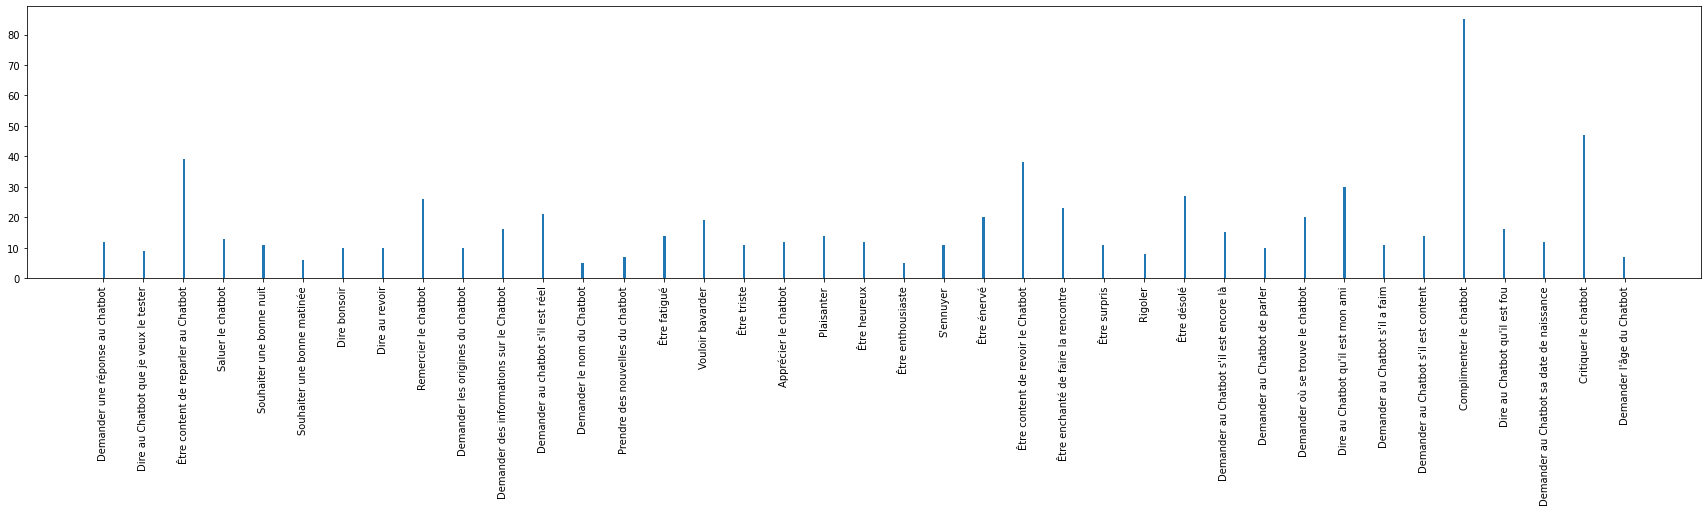

In [ ]:
plt.figure(figsize=(30,5))
plt.hist(intents, bins=len(intents))
plt.xticks(rotation='vertical')
plt.show()

# Extract TFIDF

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

import pandas 

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import FrenchStemmer
from nltk.stem import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
alphanumeric_characters = {
    "fr": "a-zA-ZàâäôéèëêïîçùûüÿæœÀÂÄÔÉÈËÊÏÎŸÇÙÛÜÆŒ0-9",
    "en": "a-zA-Z0-9"
}

words_unsplitted = ["don't", "you're", "i'm",
                    "aujourd'hui", "n'es", "n'est", "n'êtes", "d'accord"]

def tokenize_text(text, language):
    delimiter_pattern = '[^' + alphanumeric_characters[language] + ']'

    words = text.split()

    tokens = []
    for word in words:
        if word not in words_unsplitted:
            tokens = tokens + re.split(delimiter_pattern, word)
        else:
            tokens.append(word)

    tokens = filter(lambda x: len(x) > 1, tokens)
    tokens = [w.lower() for w in tokens]

    return tokens

In [ ]:
tokenize_text("peux tu m'aider espresso-pan-conna", 'fr')

['peux', 'tu', 'aider', 'espresso', 'pan', 'conna']

In [ ]:
def _customize_stopwords(text_list):
    """
    If stopword is present in a short training phrase (e.g. < 5 words), do not consider it as stopword.
    :param text_list:
    :return:
    """

    # custom stopwords
    raw_stopwords = list(set(stopwords.words('french')))

    words_of_short_texts = []
    for text in text_list:
        text_words = tokenize_text(text=text, language='fr')
        if len(text_words) <= 5:
            words_of_short_texts.extend(tokenize_text(text=text, language='fr'))

    selected_stopwords = [stw for stw in raw_stopwords if stw not in words_of_short_texts]

    included_stw = ['in', 'on', 'of', 'and']  # add english stw
    selected_stopwords = selected_stopwords + included_stw

    print(f'{len(selected_stopwords)} selected stopwords')
    print(f'{(selected_stopwords)}')

    return selected_stopwords

In [ ]:
class Stemming(object):
    def __init__(self):
        self.fr_stm = FrenchStemmer(ignore_stopwords=True)
        self.en_stm = SnowballStemmer("english", ignore_stopwords=True)

    def __call__(self, text, language='fr'):

        # TODO: different tfidf vectorizers, stemmers for en and fr
        language = 'fr'
        if language == 'en':
            return [self.en_stm.stem(t) for t in tokenize_text(text, language)]
        elif language == 'fr':
            return [self.fr_stm.stem(t) for t in tokenize_text(text, language)]

In [ ]:
def train_tfidf(messages):
        # custom stopwords
        stw = _customize_stopwords(text_list=messages)

        vectorizer = TfidfVectorizer(lowercase=True, stop_words=stw, use_idf=True,
                                     tokenizer=Stemming(), ngram_range=(1, 1))
        vectorizer.fit(messages)

        print(f"{len(vectorizer.get_feature_names_out())} words in vocabulary")
        print(vectorizer.get_feature_names_out())

        return vectorizer

def transform_tfidf(vectorizer, messages):

        return vectorizer.transform(messages)

In [ ]:
def preprocess_messages(messages):
  
  cleaned_messages = []

  stw = _customize_stopwords(messages)

  for m in messages: 
    cleaned_m = " ".join([w for w in m.split() if w not in stw])
    cleaned_messages.append(cleaned_m)
    if m != cleaned_m:
      print(f"{m} : {cleaned_m}")

  return cleaned_messages

In [ ]:
# messages = preprocess_messages(messages)

In [ ]:
vectorizer = train_tfidf(messages)
tfidf = transform_tfidf(vectorizer, messages)

115 selected stopwords
['serez', 'seras', 'elle', 'les', 'ayante', 'sa', 'ont', 'étais', 'aurons', 'ils', 'êtes', 'seriez', 'seraient', 'étiez', 'étés', 'étantes', 't', 'avons', 'avaient', 'eues', 'sommes', 'fûmes', 'eus', 'ait', 's', 'ayez', 'eût', 'aura', 'ces', 'son', 'eussiez', 'aux', 'par', 'y', 'm', 'étants', 'auront', 'j', 'soyons', 'sur', 'soit', 'votre', 'serions', 'l', 'avait', 'ayantes', 'nos', 'eussions', 'aurai', 'sois', 'lui', 'sera', 'étées', 'auriez', 'ayant', 'étions', 'avais', 'furent', 'soyez', 'fûtes', 'notre', 'eurent', 'aurais', 'mais', 'avez', 'étante', 'c', 'eue', 'serait', 'fussiez', 'ayons', 'fussent', 'aurions', 'fus', 'fusses', 'auraient', 'vos', 'fût', 'aurait', 'eusses', 'seront', 'à', 'avions', 'étaient', 'ses', 'serons', 'aie', 'fusse', 'aient', 'fussions', 'auras', 'aies', 'leur', 'eu', 'fut', 'eûtes', 'étée', 'aviez', 'aurez', 'ayants', 'eux', 'étant', 'eûmes', 'eussent', 'du', 'n', 'soient', 'eusse', 'eut', 'd', 'serai', 'in', 'on', 'of', 'and']
298 w

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(messages[0])

j'ai une question espresso-pan-conna


In [ ]:
print(f"Shape of tfidf of training data :  {tfidf.shape}")
print(f"\t{tfidf.shape[0]} vectors tfidf")
print(f"\t{tfidf.shape[1]} dimensions in each vector")

Shape of tfidf of training data :  (687, 295)
	687 vectors tfidf
	295 dimensions in each vector


In [ ]:
if testing_data_fn:
  testing_tfidf = transform_tfidf(vectorizer, test_messages)
  print(f"Shape of tfidf of testing data :  {testing_tfidf.shape}")
  print(f"\t{testing_tfidf.shape[0]} vectors tfidf")
  print(f"\t{testing_tfidf.shape[1]} dimensions in each vector")

# Extract BERT features

### Initialize model

In [ ]:
config = AutoConfig.from_pretrained(pre_trained_model, output_hidden_states=True)
model = AutoModel.from_pretrained(pre_trained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model, do_lower_case=True)


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenize 

In [ ]:
def extract_bert_output(messages):

  tokenized_messages = tokenizer(
      messages,
      add_special_tokens=True,
      # padding="longest",
      max_length=100,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
  )

  print(f"Nb of tokenized messages : {len(tokenized_messages.input_ids)}")
  print(f"Size of tokenized message (with padding) : {len(tokenized_messages.input_ids[0])}")

  sentences_tokens = [tokenizer.convert_ids_to_tokens(sentence_input_ids) for sentence_input_ids in tokenized_messages['input_ids']]
  for st in sentences_tokens[0:5]: 
      pprint([t for t in st][:30], width=150)

  print('\nLongest sentences :')
  for st in sentences_tokens: 
      if len(st) == len(tokenized_messages.input_ids[0]) and '<pad>' not in st:
        pprint([t for t in st][:30], width=150)

  with torch.no_grad():
      model_output = model(**tokenized_messages, output_hidden_states=True)

  return model_output

In [ ]:
model_output = extract_bert_output(messages)

Nb of tokenized messages : 687
Size of tokenized message (with padding) : 100
['<s>',
 '▁j',
 "'",
 'ai',
 '▁une',
 '▁question',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']
['<s>',
 '▁il',
 '▁me',
 '▁faut',
 '▁une',
 '▁réponse',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']
['<s>',
 '▁j',
 "'",
 'ai',
 '▁besoin',
 '▁d',
 "'",
 'une',
 '▁réponse',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']
['<s>',
 '▁donne',
 '▁une',
 '▁réponse',
 '</s>',
 '<p

In [ ]:
testing_model_output = None

if testing_data_fn:
  testing_model_output = extract_bert_output(test_messages)

## Extract last hidden layer
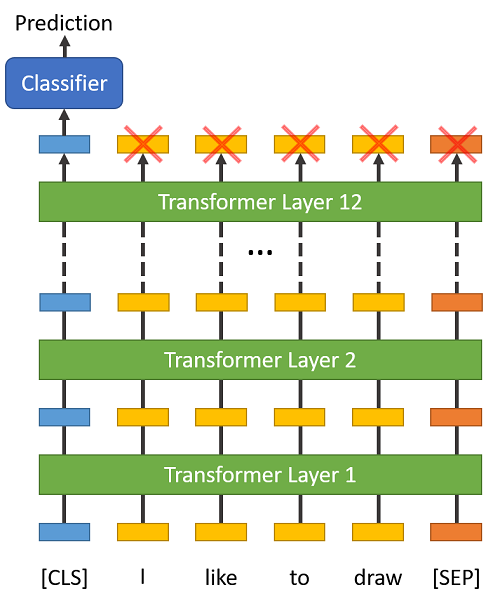

In [ ]:
# hidden representations for each token in each sequence of the batch
print(f'Training data :')
print(f"\tShape of last hidden state in output : {model_output.last_hidden_state.shape}")
print(f"\tNumber of hidden states : {len(model_output.hidden_states)}")

if testing_data_fn:
  print(f'Testing data :')
  print(f"\tShape of last hidden state in output : {testing_model_output.last_hidden_state.shape}")
  print(f"\tNumber of hidden states : {len(testing_model_output.hidden_states)}")


Training data :
	Shape of last hidden state in output : torch.Size([687, 100, 768])
	Number of hidden states : 13


In [ ]:
bert_features = model_output.last_hidden_state[:,0,:]

if testing_data_fn:
  testing_bert_features = testing_model_output.last_hidden_state[:,0,:]


In [ ]:
print(bert_features.shape)

if testing_data_fn:
  print(testing_bert_features.shape)

torch.Size([687, 768])


In [ ]:
bert_features[0]

tensor([-7.3174e-02,  1.2458e-01,  1.0263e-01, -1.7118e-01, -1.2582e-03,
         5.6968e-02,  2.1315e-02,  2.4261e-01,  2.3553e-03,  1.9085e-01,
        -2.1273e-02,  1.3765e-01, -3.4789e-02,  8.5201e-02,  2.9978e-01,
        -3.4640e-02, -8.7928e-03, -5.4016e-02,  6.3165e-02, -1.8941e-01,
         1.8459e-02, -1.1943e-01,  1.7526e-02, -2.7623e-01,  1.7014e-01,
        -1.7124e-01, -1.4844e-02, -7.5239e-02, -7.4894e-02,  2.7045e-02,
         3.6821e-02, -2.5106e-01,  1.7001e-01,  9.6920e-02,  1.0878e-01,
        -9.3555e-02, -9.9277e-02,  1.9683e-01, -1.2687e-01, -1.4408e-02,
        -2.0225e-01,  1.4373e-01,  1.4816e-01, -2.7760e-02,  2.0939e-02,
         1.8482e-01, -2.5626e-01,  6.7797e-02, -4.5383e-02,  7.1551e-02,
         2.1650e-02, -2.6728e-02, -4.9787e-01,  1.7052e-01, -1.4214e-02,
         7.4180e-02, -4.6517e-03, -1.0053e-01,  1.4897e-01,  1.0752e-02,
         4.7160e-02,  4.6161e-02,  9.6796e-02,  5.0617e-03, -1.9393e-02,
         8.0799e-02, -9.5398e-02,  1.2692e-01,  5.9

## Combining last hidden states 

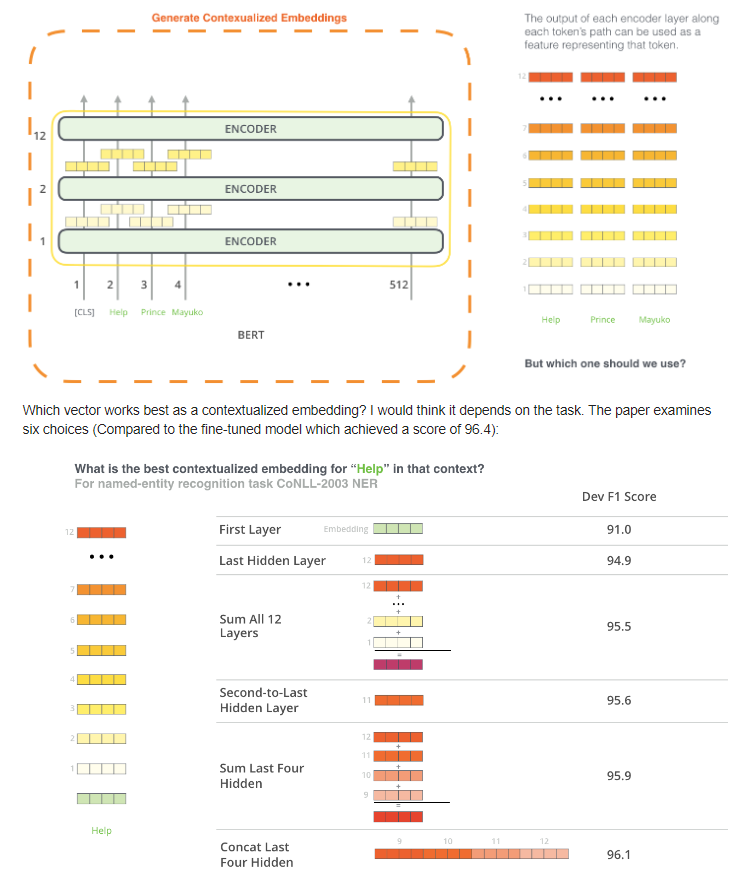

Source : http://jalammar.github.io/illustrated-bert/

### Concatenation

In [ ]:
bert_4_layers_concatenated = torch.cat(tuple([model_output.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
bert_4_layers_concatenated = bert_4_layers_concatenated[:, 0, :]
print(bert_4_layers_concatenated.shape)

if testing_data_fn:
  testing_bert_4_layers_concatenated = torch.cat(tuple([testing_model_output.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
  testing_bert_4_layers_concatenated = testing_bert_4_layers_concatenated[:, 0, :]
  print(testing_bert_4_layers_concatenated.shape)

torch.Size([687, 3072])


In [ ]:
# test
bert_4_layers_concatenated[10, -768:] == bert_features[10]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

### Mean pooling

In [ ]:
bert_4_layers_avg = [model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
bert_4_layers_avg = torch.stack(bert_4_layers_avg, dim=1)
bert_4_layers_avg = torch.mean(bert_4_layers_avg, dim=1)
print(bert_4_layers_avg.shape)

if testing_data_fn:
  testing_bert_4_layers_avg = [testing_model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
  testing_bert_4_layers_avg = torch.stack(testing_bert_4_layers_avg, dim=1)
  testing_bert_4_layers_avg = torch.mean(testing_bert_4_layers_avg, dim=1)
  print(testing_bert_4_layers_avg.shape)

torch.Size([687, 768])


In [ ]:
bert_4_layers_avg[0]

tensor([-1.7565e-02,  3.3650e-02,  1.2822e-02, -6.7238e-02,  4.6930e-03,
         1.8761e-02,  3.3632e-03,  6.3148e-02, -1.0030e-02,  3.6905e-02,
        -3.5349e-03,  1.7032e-02,  1.9071e-03,  1.1593e-02,  7.3893e-02,
        -1.0289e-03, -5.7755e-03,  1.5230e-03,  1.4516e-02, -4.1334e-02,
        -6.1392e-03, -3.4776e-02, -1.7669e-02, -6.1088e-02,  8.4762e-02,
        -2.2312e-02, -1.3737e-02, -2.9700e-02, -1.6064e-02,  1.1848e-02,
         4.0456e-03, -6.8519e-02,  4.6865e-02,  2.9188e-02,  3.8047e-02,
        -2.8625e-02, -2.4122e-02,  5.7673e-02, -4.4534e-02,  1.2329e-02,
        -5.1142e-02,  3.5486e-02,  3.9577e-02, -8.7407e-03,  5.1353e-03,
         4.6583e-02, -5.3286e-02,  9.4732e-02, -1.3186e-02,  1.1470e-02,
        -2.8764e-03,  3.1069e-03, -1.8958e-01,  4.9125e-02, -1.1603e-02,
         6.9674e-03,  1.6622e-04, -7.0327e-02,  3.8642e-02,  1.9445e-02,
         7.5539e-03,  1.6627e-03,  2.4063e-02, -2.1995e-03,  7.0724e-03,
         4.4370e-02, -1.0208e-02,  2.9639e-02,  2.0

In [ ]:
# test to validate
s = 0
for i in [-4, -3, -2, -1]:
    embedding_i = model_output.hidden_states[i][0, 0, :]
    print(embedding_i.shape)
    print(embedding_i[5])
    s += embedding_i[5]

print(f'mean : {s/4.0}')

torch.Size([768])
tensor(0.0014)
torch.Size([768])
tensor(0.0010)
torch.Size([768])
tensor(0.0156)
torch.Size([768])
tensor(0.0570)
mean : 0.018760617822408676


### Max pooling


In [ ]:
bert_4_layers_max = [model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
bert_4_layers_max = torch.stack(bert_4_layers_max, dim=1)
bert_4_layers_max = torch.max(bert_4_layers_max, dim=1)
bert_4_layers_max = bert_4_layers_max.values
print(bert_4_layers_max.shape)

if testing_data_fn:
  testing_bert_4_layers_max = [testing_model_output.hidden_states[i][:, 0, :] for i in [-4, -3, -2, -1]]
  testing_bert_4_layers_max = torch.stack(testing_bert_4_layers_max, dim=1)
  testing_bert_4_layers_max = torch.max(testing_bert_4_layers_max, dim=1)
  testing_bert_4_layers_max = testing_bert_4_layers_max.values
  print(testing_bert_4_layers_max.shape)

torch.Size([687, 768])


In [ ]:
# test to validate
# each element in hidden_states : [# layers, # batches, # tokens, # features]
max_values = []
look_at_position = -2

for i in [-4, -3, -2, -1]:
    embedding_1st_token_1st_message_at_layer_i = model_output.hidden_states[i][0, 0, :]
    # print(embedding_1st_token_1st_message_at_layer_i.shape)
    print(embedding_1st_token_1st_message_at_layer_i[look_at_position])
    max_values.append(embedding_1st_token_1st_message_at_layer_i[look_at_position])

print(f'max : {max(max_values)}')

tensor(-0.0015)
tensor(0.0246)
tensor(0.0048)
tensor(-0.0931)
max : 0.02455226331949234


In [ ]:
bert_4_layers_max[0][look_at_position]

tensor(0.0246)

# Classify intents

In [ ]:
configs_name = f"{len(all_intents_name)}intents=={pre_trained_model}=={features_name}=={classifier_name}"
print(configs_name)

39intents==camembert-base==tfidf==SVM


## Select features & model name

In [ ]:
features = None

if features_name == "bert_1_layer":
  features = bert_features
if features_name == "bert_4_layers_concatenated":
  features = bert_4_layers_concatenated
if features_name == "bert_4_layers_avg":
  features = bert_4_layers_avg
if features_name == "bert_4_layers_max":
  features = bert_4_layers_max
if features_name == "tfidf":
  features = tfidf

In [ ]:
print(f"Features name : {features_name}")
print(f"Features shape : {features.shape}")
print(features[0])

Features name : tfidf
Features shape : (687, 295)
  (0, 269)	0.45762025500619585
  (0, 208)	0.6579561373456513
  (0, 6)	0.5980613877665526


In [ ]:
test_features = None

if testing_data_fn:

  if features_name == "bert_1_layer":
    test_features = testing_bert_features
  if features_name == "bert_4_layers_concatenated":
    test_features = testing_bert_4_layers_concatenated
  if features_name == "bert_4_layers_avg":
    test_features = testing_bert_4_layers_avg
  if features_name == "bert_4_layers_max":
    test_features = testing_bert_4_layers_max
  if features_name == "tfidf":
    test_features = testing_tfidf

  print(f"Testing features name : {features_name}")
  print(f"Testing features shape : {test_features.shape}")
  print(test_features[0])

## Normalize

In [ ]:
def normalize_bert_features(features):

  if features_name == "tfidf":
    return features

  transformer = Normalizer().fit(features)
  features = transformer.transform(features)

  print(f"Features name : {features_name}")
  print(f"Features shape : {features.shape}")

  return features

In [ ]:
features = normalize_bert_features(features)

if testing_data_fn:
  test_features = normalize_bert_features(test_features)

## Split to train and test

In [ ]:
if not testing_data_fn:
  train_messages, test_messages, train_features, test_features, train_labels, test_labels = train_test_split(messages, features, intents, test_size=0.2, stratify=intents, random_state=42)
else:
  train_messages = messages
  train_features = features
  train_labels = intents

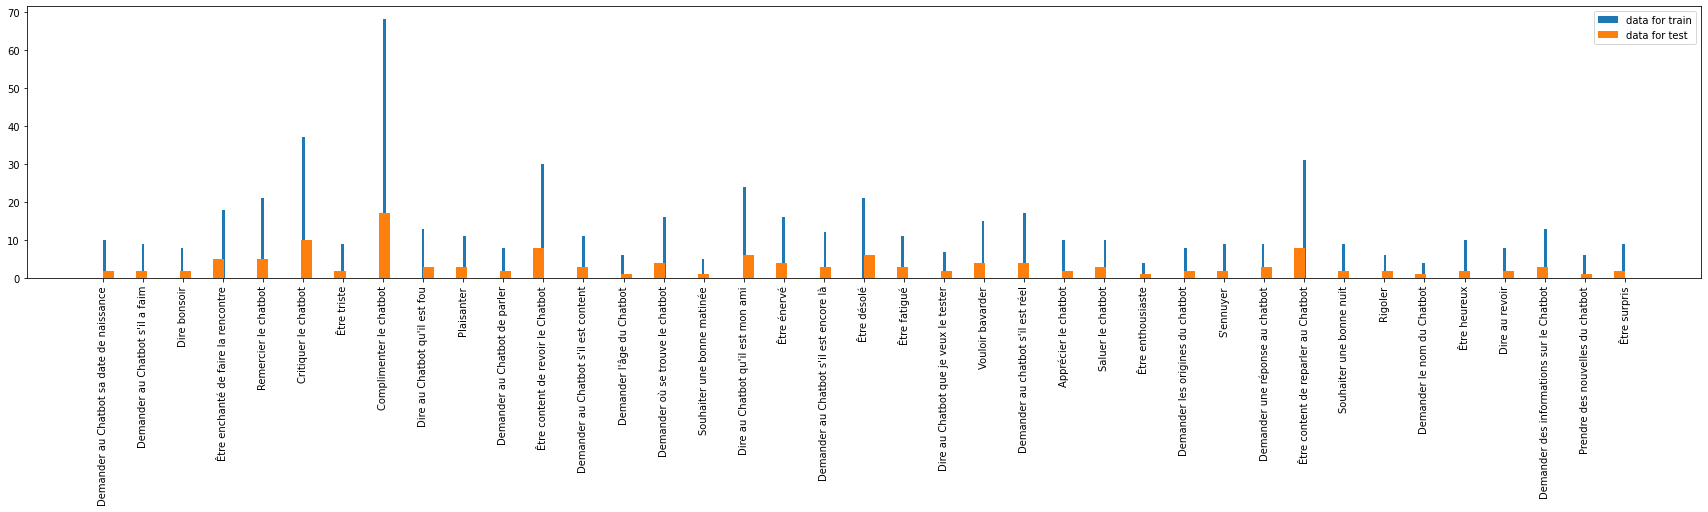

In [ ]:
plt.figure(figsize=(30,5))
plt.hist(train_labels, bins=len(train_labels), label="data for train")
plt.hist(test_labels, bins=len(test_labels), label="data for test")
plt.legend(loc='upper right')

plt.xticks(rotation='vertical')
plt.show()

In [ ]:
if features_name == "tfidf":
  train_features = train_features.toarray()
  test_features = test_features.toarray()

print(len(train_features))
print(len(test_features))

print(len(train_features) / (len(train_features) + len(test_features)))
print(len(test_features) / (len(train_features) + len(test_features)))


549
138
0.7991266375545851
0.20087336244541484


In [ ]:
# display training and testing messages for each intent
for intent_ in list(set(all_intents)):
  print(f'{intent_}')
  print(f'\tTrainings:')
  for i in range(len(train_labels)):
    if train_labels[i] == intent_:
      print(f'\t\t{train_messages[i]}')
  print(f'\tTestings:')
  for i in range(len(test_labels)):
    if test_labels[i] == intent_:
      print(f'\t\t{test_messages[i]}')
  

Prendre des nouvelles du chatbot
	Trainings:
		bien ou bien
		Comment allez-vous
		Vous allez bien ?
		Tu vas bien?
		Comment vas-tu
		ça va ?
	Testings:
		Comment va
Demander au Chatbot s'il est encore là
	Trainings:
		tu es ici
		tu es toujours ici
		tu es ici ou non
		t'es là
		t'es là toi
		es-tu ici
		t'es toujours là
		t'es là ou pas
		es-tu toujours là
		es-tu là
		est-ce que tu es là
		es-tu toujours ici
	Testings:
		tu es là
		est-ce que tu es ici
		t'es toujours ici
Demander au Chatbot sa date de naissance
	Trainings:
		ton anniversaire c'est quand
		quelle est la date de ton anniv
		donne-moi ta date de naissance
		la date de ta naissance
		quand est-ce que tu fêtes ton anniversaire
		la date de ton anniv
		dis-moi la date de ton anniversaire
		quelle est la date de ta naissance
		quelle est ta date de naissance
		il est quand ton anniversaire
	Testings:
		quand est ton anniversaire
		c'est quand ton anniversaire
Être triste
	Trainings:
		ça me donne envie de pleurer
		je me

## Oversample training data 

In [ ]:
oversampled_train_labels = []
oversampled_train_features = []
oversampled_train_messages = []

training_counter = Counter(train_labels)

max_size_intent = max(training_counter.values())
print(f'Number of messages in the biggest intent : {max_size_intent}')

for intent_, count_ in training_counter.items():

  intent_phrases = []
  intent_features = []

  for i in range(len(train_labels)):
    if train_labels[i] == intent_:
      intent_phrases.append(train_messages[i])
      intent_features.append(train_features[i])

  print(f"\t{intent_} : {count_}")

  if count_ < max_size_intent:
    nb_dupplicate = max_size_intent // count_
    remainder = max_size_intent % count_
    
    print(f'\t\toversample : {nb_dupplicate} * {count_} + {remainder}')

    new_intent_phrases = intent_phrases * nb_dupplicate + intent_phrases[:remainder]
    new_intent_features = intent_features * nb_dupplicate + intent_features[:remainder]

    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_features = oversampled_train_features + new_intent_features
    oversampled_train_messages = oversampled_train_messages + new_intent_phrases

    if not len(oversampled_train_labels) == len(oversampled_train_features) == len(oversampled_train_messages):
      print('NOT OK')

  else:
    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_features = oversampled_train_features + intent_features
    oversampled_train_messages = oversampled_train_messages + intent_phrases

print(len(oversampled_train_labels))
print(len(oversampled_train_features))
print(len(oversampled_train_messages))

Number of messages in the biggest intent : 68
	Demander au Chatbot sa date de naissance : 10
		oversample : 6 * 10 + 8
	Demander au Chatbot s'il a faim : 9
		oversample : 7 * 9 + 5
	Dire bonsoir : 8
		oversample : 8 * 8 + 4
	Être enchanté de faire la rencontre : 18
		oversample : 3 * 18 + 14
	Remercier le chatbot : 21
		oversample : 3 * 21 + 5
	Critiquer le chatbot : 37
		oversample : 1 * 37 + 31
	Être triste : 9
		oversample : 7 * 9 + 5
	Complimenter le chatbot : 68
	Dire au Chatbot qu'il est fou : 13
		oversample : 5 * 13 + 3
	Plaisanter : 11
		oversample : 6 * 11 + 2
	Demander au Chatbot de parler : 8
		oversample : 8 * 8 + 4
	Être content de revoir le Chatbot : 30
		oversample : 2 * 30 + 8
	Demander au Chatbot s'il est content : 11
		oversample : 6 * 11 + 2
	Demander l'âge du Chatbot : 6
		oversample : 11 * 6 + 2
	Demander où se trouve le chatbot : 16
		oversample : 4 * 16 + 4
	Souhaiter une bonne matinée : 5
		oversample : 13 * 5 + 3
	Dire au Chatbot qu'il est mon ami : 24
		overs

In [ ]:
train_labels = oversampled_train_labels
train_messages = oversampled_train_messages
train_features = oversampled_train_features

## Train model

In [ ]:
if classifier_name == "LogisticRegression":
    classifier = LogisticRegression(random_state=42)

    parameters = {'C': np.linspace(0.0001, 100, 20)}

if classifier_name == "SVM":
    classifier = SVC(random_state=42, probability=True, class_weight='balanced')

    c_values = [1.0,10.0,100.0,500.0,1000.0]
    g_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    d_values = [2,3,4]    
    parameters=[{'C': c_values,'kernel': ['linear']},
                {'C': c_values,'kernel': ['rbf'],'gamma': g_values} ,
                {'C': c_values,'kernel': ['poly'],'gamma': g_values,'degree': d_values}
               ]

print(classifier)
print(parameters)

SVC(class_weight='balanced', probability=True, random_state=42)
[{'C': [1.0, 10.0, 100.0, 500.0, 1000.0], 'kernel': ['linear']}, {'C': [1.0, 10.0, 100.0, 500.0, 1000.0], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}, {'C': [1.0, 10.0, 100.0, 500.0, 1000.0], 'kernel': ['poly'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'degree': [2, 3, 4]}]


In [ ]:
start_time = time.time()

# Grid search
grid_search = GridSearchCV(classifier, parameters, cv=5)
grid_search.fit(train_features, train_labels)

print(f'Number of data for training : {len(train_features)}')
print(f'Number of intents : {len(set(train_labels))}')

print('Best parameters : ', grid_search.best_params_)
print('Best score : ', grid_search.best_score_)

print(f"Training time : {(time.time() - start_time)}")

Number of data for training : 2652
Number of intents : 39
Best parameters :  {'C': 1.0, 'degree': 4, 'gamma': 0.9, 'kernel': 'poly'}
Best score :  0.9996226415094339
Training time : 1875.3919968605042


In [ ]:
print(f'Number of data for training : {len(train_features)}')
print(f'Number of intents : {len(set(train_labels))}')

In [ ]:
if classifier_name == "LogisticRegression":
  classifier = LogisticRegression(**grid_search.best_params_)

if classifier_name == "SVM":
  classifier=SVC(**grid_search.best_params_, random_state=42, probability=True, class_weight='balanced')

print(classifier)

In [ ]:
classifier.fit(train_features, train_labels)

## Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:

    _, ax = plt.subplots(figsize=(15,15))

    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_features,
        test_labels,
        # cmap=plt.cm.Blues,
        normalize=normalize,
        xticks_rotation='vertical',
        ax=ax
    )

    configs_name = configs_name.replace('/', '-')
    disp.figure_.savefig(f'{configs_name}==normalized{normalize}_CM.png')


In [ ]:
from sklearn.metrics import confusion_matrix

predictions =classifier.predict(test_features)


nb_incorrect_detection = 0

for i in range(len(test_features)):
  if predictions[i] != test_labels[i]:
    nb_incorrect_detection += 1
    print(f"{test_messages[i]}")
    print(f"\tlabel {test_labels[i]} != predicted {predictions[i]}")

print(f'\nNumber of incorrect detection : {nb_incorrect_detection}')

Observations on incorrect prediction :
1. Labeling not propre 

```
T'es qui toi ?
  label Demander le nom du Chatbot != predicted Demander des informations sur le Chatbot
```

2. Imbalanced classes 

```
c'est trop triste
  label Être triste (11 training) != predicted Complimenter le chatbot (>80 training)
```






In [ ]:
from sklearn.metrics import classification_report

y_pred=classifier.predict(test_features)

print(classification_report(test_labels, y_pred, labels=list(set(test_labels))))

clsf_report = pandas.DataFrame(classification_report(y_true = test_labels, y_pred = y_pred, output_dict=True, labels=list(set(test_labels)))).transpose()
clsf_report.to_csv(f'{configs_name}_metrics.csv', index= True)


## Evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

def evaluate(test_labels, y_pred):
    acc=accuracy_score(test_labels,y_pred)
    print('Accuracy : ', round(acc,2))

    f1_sc = f1_score(test_labels, y_pred, average='macro')
    print('F1 Score (macro) : ', round(f1_sc, 2))

    print(f'% incorrect detection : {round(nb_incorrect_detection / len(test_labels), 2)}')

In [ ]:
evaluate(test_labels, y_pred)

In [ ]:
def intent_never_predicted(test_labels, test_pred):
  return set(test_labels) - set(test_pred)

print(f"These intents are never predicted for testing data :")
for i in intent_never_predicted(test_labels, y_pred):
  print(f"\t{i}")

## Examine acceptation threshold

In [ ]:
# calculate score of the first intent
y_scores = classifier.predict_proba(test_features)

y_highest_scores = []

for y_score in y_scores:
  highest_score = max(zip(classifier.classes_, y_score), key=lambda x: x[1])
  y_highest_scores.append(highest_score)

min_score = min(y_highest_scores, key=lambda x: x[1])
max_score = max(y_highest_scores, key=lambda x: x[1])
print(f"Min score on test : {min_score[1]}")
print(f"Max score on test : {max_score[1]}")

# for i in range(len(test_messages)):
#   print(f"{test_messages[i]} : {y_highest_scores[i]}")

In [ ]:
def decision(threshold, y_highest_scores, test_labels, test_messages):
  correct_pred = 0
  incorrect_pred = 0
  no_pred = 0

  for i in range(len(test_messages)):
    intent_, score_ = y_highest_scores[i]

    if score_ >= threshold:
      if intent_ == test_labels[i]:
        correct_pred += 1
      else:
        incorrect_pred += 1
    else:
      no_pred += 1

  return correct_pred, incorrect_pred, no_pred

In [ ]:
thresholds = (0.05, 0.95, 0.05)

threshold_values = np.arange(thresholds[0], thresholds[1], thresholds[2])

threshold_values = [round(th, 2) for th in threshold_values]

correct_pred_values = []
incorrect_pred_values = []
no_pred_values = []

for th in threshold_values:
  cr, incr, npr = decision(th, y_highest_scores, test_labels, test_messages)

  print(f"Threshold = {th}")
  print(f"\t% correct pred : {cr}/{len(test_messages)} = {round(cr/len(test_messages), 2)}")
  print(f"\t% incorrect pred : {incr}/{len(test_messages)} = {round(incr/len(test_messages), 2)}")
  print(f"\t% no pred : {npr}/{len(test_messages)} = {round(npr/len(test_messages), 2)}")

  correct_pred_values.append(round(cr/len(test_messages), 2))
  incorrect_pred_values.append(round(incr/len(test_messages), 2))
  no_pred_values.append(round(npr/len(test_messages), 2))

In [ ]:
fig, ax = plt.subplots()

ax.plot(threshold_values, correct_pred_values, color='green', label='correct prediction')
ax.plot(threshold_values, incorrect_pred_values, color='red', label='incorrect prediction')
ax.plot(threshold_values, no_pred_values, color='blue', label='no prediction')

ax.legend(loc='best', frameon=False)

plt.title(f"{configs_name}")

plt.savefig(f"{configs_name}_thresholds.png")

plt.show()


# Fine tune BERT

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# Clustering using BERT features

In [ ]:
def k_means_clustering(features, num_clusters):

    clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
    clustering_model.fit(features)
    cluster_assignment = clustering_model.labels_

    clustered_messages = [[] for i in range(num_clusters)]

    cluster_intents = {}

    for message_id, cluster_id in enumerate(cluster_assignment):
        clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

    for i, cluster in enumerate(clustered_messages):

        intents_in_cluster = [i for m, i in cluster]
        intents_counter = Counter(intents_in_cluster)

        print(f"Cluster {i+1}")
        print(f"\t{len(cluster)} phrases")
        print(f"\t{len(intents_counter)} classes")

        intents_ = {}

        for intent_, count_ in intents_counter.items():
          print(f"\t\t{intent_} : {count_}")
          messages_ = [m for m, i in cluster if i == intent_]
          display = '\n\t\t\t'.join(messages_)
          print(f"\t\t\t{display}")

          intents_[intent_] = count_

        cluster_intents[i+1] = intents_

    return cluster_intents    

In [ ]:
def visualize_kmeans_clusters(cluster_intents):
    intents_array = []
    clusters_array = []
    labels_array = []

    for cluster_id, intents_in_cluster in cluster_intents.items():
        for intent_ in all_intents_name:
            intents_array.append(intent_)
            clusters_array.append(cluster_id)
            if intent_ in intents_in_cluster:
                labels_array.append(round(intents_in_cluster[intent_] / nb_phrases_in_intents[intent_], 2))
            else:
                labels_array.append(0)

    df = pandas.DataFrame.from_dict(np.array([intents_array, clusters_array, labels_array]).T)
    df.columns = ['intents','clusters','labels']
    df['labels'] = pandas.to_numeric(df['labels'])

    pivotted= df.pivot('clusters','intents','labels')

    plt.figure(figsize=(30,7))
    sns.heatmap(pivotted, annot=True, cmap='RdBu')
    plt.show()

Cluster 1
	66 phrases
	11 classes
		Arrêter conversation : 6
			quitter conversation
			fin de conversation
			arrête
			stop
			je veux arrêter la conversation
			je veux arrêter de te parler
		Demander qui peut acheter sur PFS : 8
			Je suis un particulier 
			La plateforme est elle ouverte à tous ?
			tout le monde peut acheter ?
			qui peut acheter sur votre plateforme
			je peux acheter ?
			je veux commander
			comment je peux commander
			qui peut passer commande
		Demander politique de confidentialité : 5
			quelle est votre politique de confidentialité ?
			politique de confidentialité
			où je trouve la politique de confidentialité
			ou est votre politique de confidentialité
			donnez moi la politique de confidentialité
		Demander application : 6
			avez-vous une application mobile que je peux télécharger ?
			y a il une application Paris fashion shop ?
			y a une application gratuite que je peux installer ?
			y a une application mobile que je peux télécharger
			où on peut

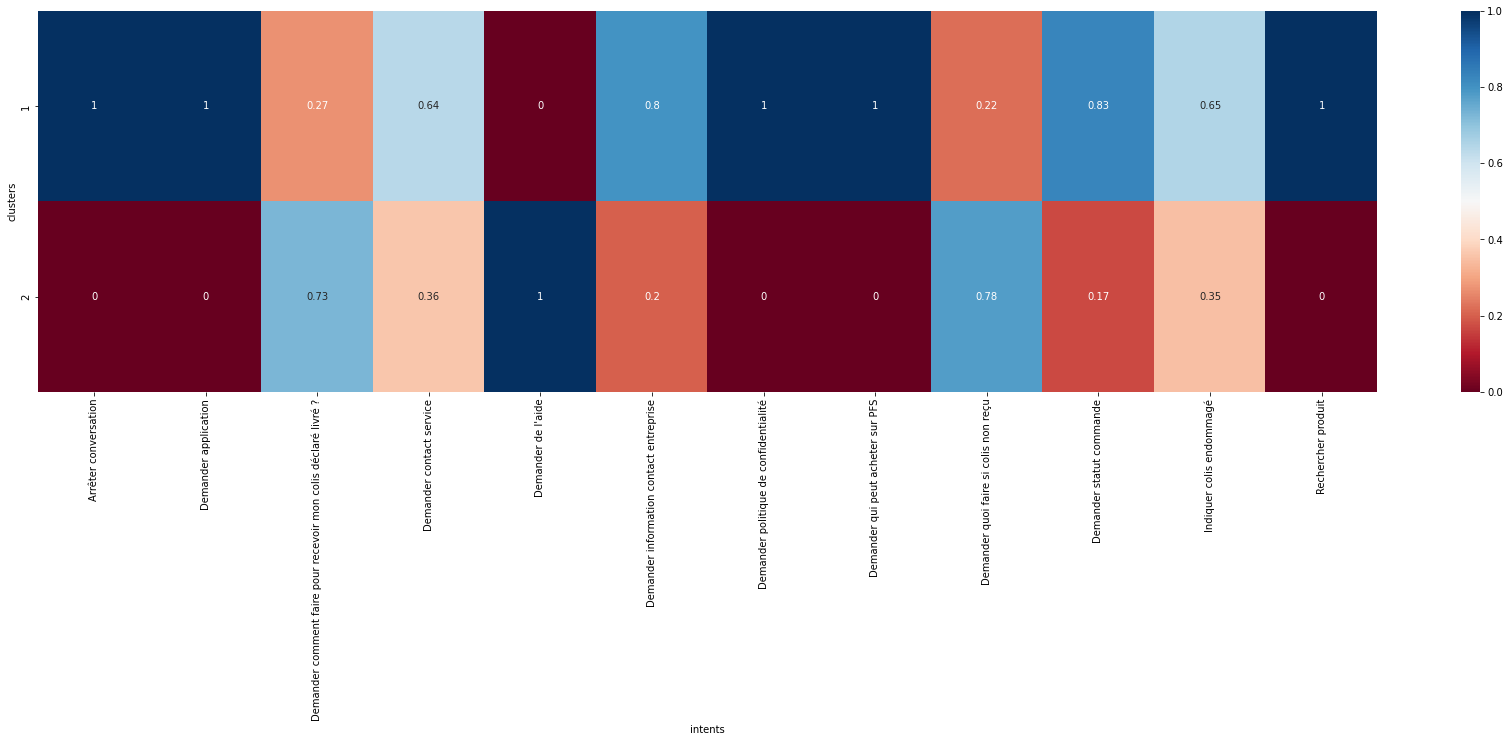

In [ ]:
cluster_intents = k_means_clustering(features, 2)
visualize_kmeans_clusters(cluster_intents)

## Clustering on cluster features

In [ ]:
def create_intent_features(all_intents_name, cluster_intents):
    intents_features = []
    for intent_ in all_intents_name:
        intent_features = []
        for cluster_id, intents_in_cluster in cluster_intents.items():
            if intent_ in intents_in_cluster:
                intent_features.append(round(intents_in_cluster[intent_] / nb_phrases_in_intents[intent_], 2))
            else:
                intent_features.append(0)
        intents_features.append(intent_features)
    return intents_features

In [ ]:
def clustering(features, num_clusters):

    clustered_intents = [[] for i in range(num_clusters)]

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(features)
    cluster_assignment = clustering_model.labels_

    for intent_id, cluster_id in enumerate(cluster_assignment):
        clustered_intents[cluster_id].append(all_intents_name[intent_id])

    return clustered_intents

In [ ]:
intents_features = create_intent_features(all_intents_name, cluster_intents)
meta_clusters = clustering(intents_features, 6)

Cluster: 1
Intents: Demander contact service, Indiquer colis endommagé


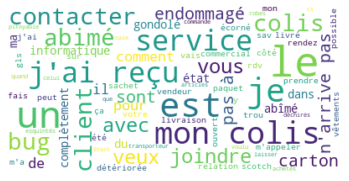

Cluster: 2
Intents: Demander quoi faire si colis non reçu


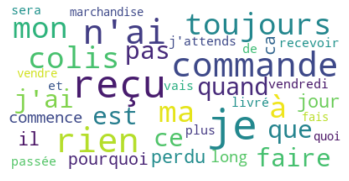

Cluster: 3
Intents: Demander qui peut acheter sur PFS, Arrêter conversation, Rechercher produit, Demander politique de confidentialité, Demander application


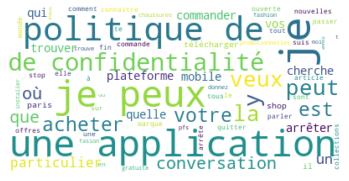

Cluster: 4
Intents: Demander statut commande, Demander information contact entreprise


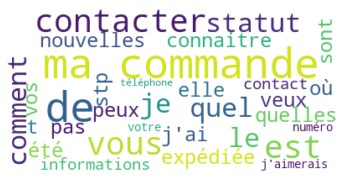

Cluster: 5
Intents: Demander de l'aide


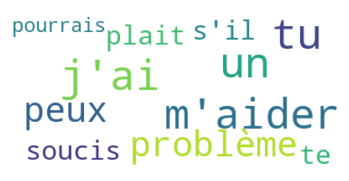

Cluster: 6
Intents: Demander comment faire pour recevoir mon colis déclaré livré ?


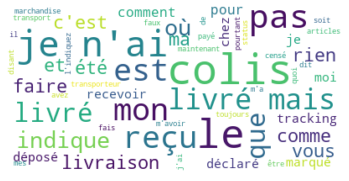

In [ ]:
def get_phrases_of_intents_in_clusters(meta_clusters):
    phrases_in_clusters = []
    for cluster in meta_clusters: 
        phrases = []
        for intent_ in cluster:
            phrases.extend(get_phrases_of_intent(intent_))
        phrases_in_clusters.append(phrases)
    return phrases_in_clusters

def get_phrases_of_intent(intent_name):
    return [messages[i] for i in range(len(messages)) if intents[i] == intent_name]

from wordcloud import WordCloud

def display_words_cloud(meta_clusters, data):
    for i_c, c in enumerate(data):
        text = ' '.join([m.lower() for m in c])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        print('Cluster: {}'.format(i_c + 1))
        print(f'Intents: {", ".join(meta_clusters[i_c])}')
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()


res = get_phrases_of_intents_in_clusters(meta_clusters)
display_words_cloud(meta_clusters, res)

In [ ]:
import networkx as nx

def aggregate_clusters(cluster_intents):

    # L = [['a','b','c'],['b','d','e'],['k'],['o','p'],['e','f'],['p','a'],['d','g']]

    cluster_intents = [list(c.keys()) for c in cluster_intents.values()]

    print(cluster_intents)

    G = nx.Graph()

    #Add nodes to Graph    
    G.add_nodes_from(sum(cluster_intents, []))

    #Create edges from list of nodes
    q = [[(s[i],s[i+1]) for i in range(len(s)-1)] for s in cluster_intents]

    for i in q:

        #Add edges to Graph
        G.add_edges_from(i)

    #Find all connnected components in graph and list nodes for each component
    return [list(i) for i in nx.connected_components(G)]

In [ ]:
aggregated_clusters = aggregate_clusters(cluster_intents)

print(f"Nb of aggregated clusters : {len(aggregated_clusters)}")
for i_c, c in enumerate(aggregated_clusters):
  print(f"Cluster {i_c + 1}")
  for cc in c:
    print(f'\t{cc}')

[['Arrêter conversation', 'Demander qui peut acheter sur PFS', 'Demander politique de confidentialité', 'Demander application', 'Rechercher produit', 'Demander contact service', 'Demander comment faire pour recevoir mon colis déclaré livré ?', 'Indiquer colis endommagé', 'Demander quoi faire si colis non reçu', 'Demander statut commande', 'Demander information contact entreprise'], ["Demander de l'aide", 'Demander contact service', 'Demander comment faire pour recevoir mon colis déclaré livré ?', 'Indiquer colis endommagé', 'Demander quoi faire si colis non reçu', 'Demander statut commande', 'Demander information contact entreprise']]
Nb of aggregated clusters : 1
Cluster 1
	Demander statut commande
	Demander contact service
	Demander qui peut acheter sur PFS
	Demander information contact entreprise
	Demander de l'aide
	Arrêter conversation
	Indiquer colis endommagé
	Demander quoi faire si colis non reçu
	Rechercher produit
	Demander politique de confidentialité
	Demander application
	

## Sentence transformer

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('distiluse-base-multilingual-cased')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [ ]:
sbert_features = embedder.encode(messages)

In [ ]:
cluster_intents = k_means_clustering(sbert_features, 3)

Cluster 1
	23 phrases
	7 classes
		Demander de l'aide : 2
			j'ai un problème
			j'ai un soucis
		Arrêter conversation : 5
			quitter conversation
			fin de conversation
			arrête
			stop
			je veux arrêter la conversation
		Demander qui peut acheter sur PFS : 1
			Je suis un particulier 
		Demander politique de confidentialité : 1
			politique de confidentialité
		Demander contact service : 4
			j'ai un bug informatique
			y a des bugs
			Bugs
			ça bug
		Indiquer colis endommagé : 9
			Mon colis est endommagé
			Mon paquet est abîmé
			Ma livraison est détériorée
			Mon colis est écorné
			Le carton du colis est gondolé
			Le sachet a été ouvert
			Les vêtements sont esquintés
			les robes sont déchirés
			mon colis est abimé
		Demander statut commande : 1
			ma commande stp
Cluster 2
	35 phrases
	4 classes
		Demander comment faire pour recevoir mon colis déclaré livré ? : 11
			Comment faire pour recevoir mon colis déclaré livré ?
			Le tracking indique mon colis comme livré mais je

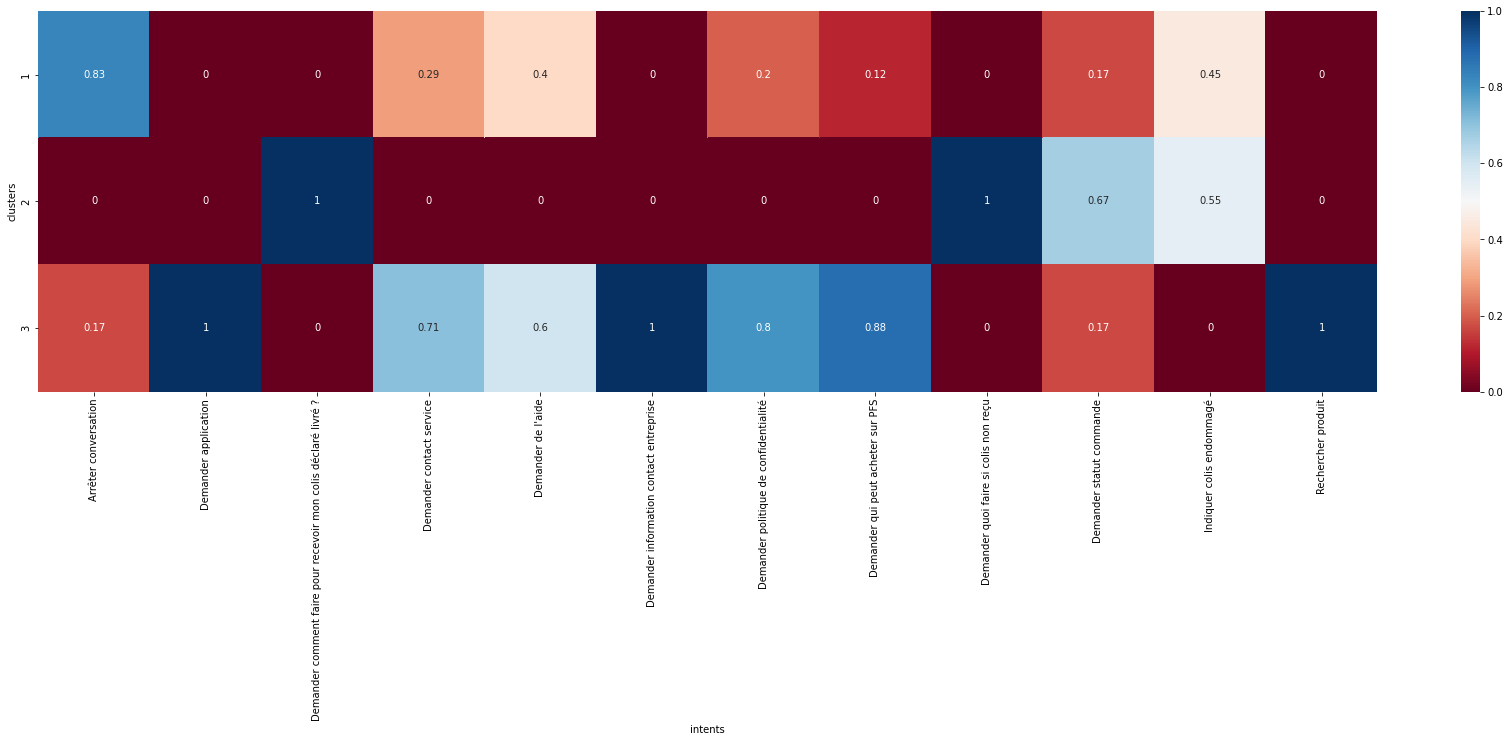

In [ ]:
visualize_kmeans_clusters(cluster_intents)

In [ ]:
aggregated_clusters = aggregate_clusters(cluster_intents)

print(f"Nb of aggregated clusters : {len(aggregated_clusters)}")
for i_c, c in enumerate(aggregated_clusters):
  print(f"Cluster {i_c + 1}")
  for cc in c:
    print(f'\t{cc}')

[["Demander de l'aide", 'Arrêter conversation', 'Demander qui peut acheter sur PFS', 'Demander politique de confidentialité', 'Demander contact service', 'Indiquer colis endommagé', 'Demander statut commande'], ['Demander comment faire pour recevoir mon colis déclaré livré ?', 'Indiquer colis endommagé', 'Demander quoi faire si colis non reçu', 'Demander statut commande'], ["Demander de l'aide", 'Arrêter conversation', 'Demander qui peut acheter sur PFS', 'Demander politique de confidentialité', 'Demander application', 'Rechercher produit', 'Demander contact service', 'Demander statut commande', 'Demander information contact entreprise']]
Nb of aggregated clusters : 1
Cluster 1
	Demander statut commande
	Demander contact service
	Demander qui peut acheter sur PFS
	Demander information contact entreprise
	Demander de l'aide
	Arrêter conversation
	Indiquer colis endommagé
	Demander quoi faire si colis non reçu
	Rechercher produit
	Demander politique de confidentialité
	Demander applicati

[['Arrêter conversation'], ['Demander contact service', 'Demander qui peut acheter sur PFS', 'Demander information contact entreprise', "Demander de l'aide", 'Rechercher produit', 'Demander politique de confidentialité', 'Demander application'], ['Demander quoi faire si colis non reçu', 'Demander comment faire pour recevoir mon colis déclaré livré ?'], ['Demander statut commande', 'Indiquer colis endommagé']]


Cluster: 1
Intents: Arrêter conversation


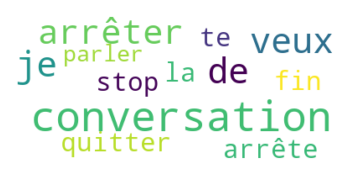

Cluster: 2
Intents: Demander contact service, Demander qui peut acheter sur PFS, Demander information contact entreprise, Demander de l'aide, Rechercher produit, Demander politique de confidentialité, Demander application


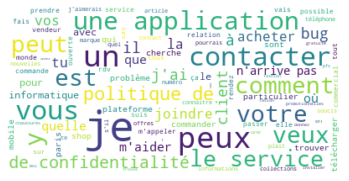

Cluster: 3
Intents: Demander quoi faire si colis non reçu, Demander comment faire pour recevoir mon colis déclaré livré ?


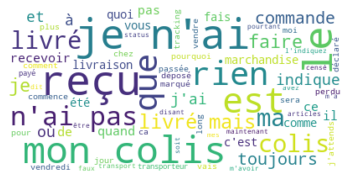

Cluster: 4
Intents: Demander statut commande, Indiquer colis endommagé


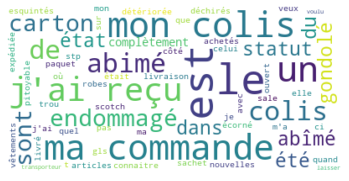

In [ ]:
intents_features = create_intent_features(all_intents_name, cluster_intents)
meta_clusters = clustering(intents_features, 4)

print(meta_clusters)
print("\n")

res = get_phrases_of_intents_in_clusters(meta_clusters)
display_words_cloud(meta_clusters, res)

In [ ]:
print(f"Encoding {len(messages)} messages ...")
corpus_embeddings = embedder.encode(messages, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Encoding 100 messages ...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=2, threshold=0.6)

print(f"Number of cluster : {len(clusters)}")

clustered_messages = [[] for i in range(num_clusters)]

intents_clusters = {}

for message_id, cluster_id in enumerate(cluster_assignment):
    clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

clustered_messages = [[] for i in range(len(clusters))]

for cluster_id in range(len(clusters)):
  for message_id in clusters[cluster_id]:
    clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

for cluster_id, cluster in enumerate(clustered_messages):

    intents_in_cluster = [i for m, i in cluster]
    intents_counter = Counter(intents_in_cluster)

    display_cluster_id = cluster_id + 1

    for intent_ in intents_counter:
      if intent_ not in intents_clusters:
        intents_clusters[intent_] = [display_cluster_id]
      else:
        intents_clusters[intent_].append(display_cluster_id)

    print(f"Cluster {display_cluster_id}")
    print(f"\t{len(cluster)} phrases")
    print(f"\t{len(intents_counter)} classes")

    for intent_, count_ in intents_counter.items():
      print(f"\t\t{intent_} : {count_}")

    print(f"\t{cluster}")
    print("")


print(intents_clusters)


Number of cluster : 21


NameError: ignored

In [ ]:
def find_clusters_by_community_detection(min_community_size=2, threshold=0.7):
    """
    #Two parameters to tune:
    #min_cluster_size: Only consider cluster that have at least 2 elements
    #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
    """
    
    intents_clusters = {} #{intent1: [cluster1, cluster2], intent2: [cluster3]}

    print(f"Encoding {len(messages)} messages ...")
    corpus_embeddings = model.encode(messages, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

    clusters = util.community_detection(corpus_embeddings, min_community_size, threshold)
    print(f"Number of cluster : {len(clusters)}")

    clustered_messages = [[] for i in range(num_clusters)]

    for message_id, cluster_id in enumerate(cluster_assignment):
        clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

    clustered_messages = [[] for i in range(len(clusters))]

    for cluster_id in range(len(clusters)):
      for message_id in clusters[cluster_id]:
        clustered_messages[cluster_id].append((messages[message_id], intents[message_id]))

    for cluster_id, cluster in enumerate(clustered_messages):

        intents_in_cluster = [i for m, i in cluster]
        intents_counter = Counter(intents_in_cluster)

        display_cluster_id = cluster_id + 1

        for intent_ in intents_counter:
          if intent_ not in intents_clusters:
            intents_clusters[intent_] = [display_cluster_id]
          else:
            intents_clusters[intent_].append(display_cluster_id)

        print(f"Cluster {display_cluster_id}")
        print(f"\t{len(cluster)} phrases")
        print(f"\t{len(intents_counter)} classes")

        for intent_, count_ in intents_counter.items():
          print(f"\t\t{intent_} : {count_}")

        print(f"\t{cluster}")
        print("")


    print(intents_clusters)

    return intents_clusters

In [ ]:
find_clusters_by_community_detection()

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# model_name = "distiluse-base-multilingual-cased-v1"
model_name = "paraphrase-multilingual-MiniLM-L12-v2"

embedder = SentenceTransformer(model_name)

# Corpus with example sentences
corpus = ['merci', 'merci beaucoup', 'merci bien', 'je te remercie', 'grand merci', "j'apprécie ça", "j'apprécie cela", "je l'apprécie", 'je suis reconnaissant', 'je suis reconnaissante', 'remerciement', 'gratitude', 'merci à toi', 'eh bien merci', 'merci bien à toi', 'je te remercie beaucoup', 'merci bcp toi', 'chui reconnaissant', 'chui reconnaissante', 'merci toi aussi', 'merci à toi aussi', 'super merci', 'merci mon ami', 'Okay, merci', "c'est noté, merci !", 'Ok, merci.', 'salut', 'bonjour à toi', 'coucou', 're salut', 'salutations', 'hé', 're bonjour', 'hey', 'allo', 'rebonjour', 'bonjour', 'salut à tous', 'resalut', 'quitter conversation', 'fin de conversation', 'arrête', 'stop', 'je veux arrêter la conversation', 'je veux arrêter de te parler']
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")